In [410]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_18'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
save_fig_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'

measures = ['Puta', 'Caud', 'Thal',
            'SN', 'STN', 'RN',  'GPi' , 'GPe',  
            #'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',
            'BrainStem', 'BasalGanglia'
            ]

drop_c = ['WSKT','SC1T','GSNT', 'SS1X', 'GSAT'] # all women scanned for MRS review. GSNT is extra. 
drop_p = ['AA8P','STDP','NL2P','HSPP'] # outliers
#drop_c = [] 
#drop_p = []


In [411]:

def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    

    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    df['L_BrainStem']    = (df['L_STN'] + df['L_SN'] +  df['L_RN']) / 3
    df['R_BrainStem']    = (df['R_STN'] + df['R_SN'] +  df['R_RN']) / 3
    df['L_BasalGanglia'] = (df['L_Puta'] + df['L_Caud'] +  df['L_Pall'] +  df['L_Accu']) / 4
    df['R_BasalGanglia'] = (df['R_Puta'] + df['R_Caud'] +  df['R_Pall'] +  df['R_Accu']) / 4
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
controls_b = get_all_dfs('QSM', 'controls', 'b', trt=True)#.drop(drop_c, axis = 0) 
patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 

controls_a['Population'] = 0
patients_a['Population'] = 1
    
controls_b.index = controls_b.index + 'b'
patients_b.index = patients_b.index + 'b'

DF_ALL =pd.concat([controls_a, patients_a], axis=0)

In [412]:
def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 
def grubbs_outliersx(df, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df, alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 


def gESD_outliersx(df, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df,maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
        
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    return result

def plot_joint(df,m1,m2, drop = []):
    DF  = pd.DataFrame([df[m1] , df[m2]] ).T.dropna()
    sns.jointplot(x=m1, y=m2, data=DF.drop(drop, axis = 0), kind = 'reg')

In [413]:
def get_resid(df,measure, regressors):
        formula = [ '%s ~ %s'%(measure,regressors[0])  + ' + %s'%regressor for regressor in regressors[1:]][0]#  
        res= smf.ols(formula=formula, data= df).fit().resid
        return res
def plt_resid(data, x, y, regressors = None, color = None, annotate = None, fig_name = None, 
              dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
              plot_marg = 1, xlim = None, ylim = None):
    
    x_resid = get_resid(data,x, regressorsx)
    y_resid = get_resid(data,y, regressorsx)
    print 'Grubbs Outliers', grubbs_outliersx(x_resid), grubbs_outliersx(y_resid)
    print 'gESD Outliers',gESD_outliersx(x_resid),gESD_outliersx(y_resid)
    df = pd.concat([x_resid, y_resid], axis=1).dropna()
    df.columns = [x,y]
    
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    formula = [ '%s ~ %s'%(y,x)][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')

    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)


# Correlation between STN-Chi & STR-Gln:Glu 

### Linear fit with no regressors 

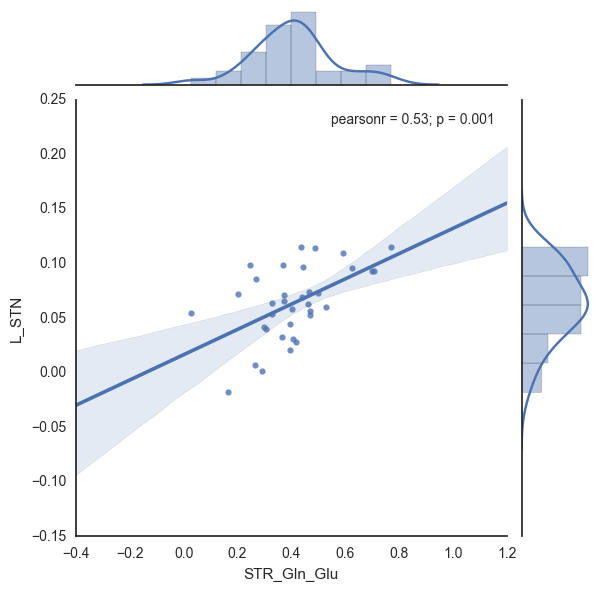

In [414]:
df = DF_ALL.drop(['YU1P'],axis=0)
x = 'STR_Gln_Glu'
y = 'L_STN'
plot_joint(df,x,y, drop = [])

## Linear fit with Age/Gender regressed from y axis

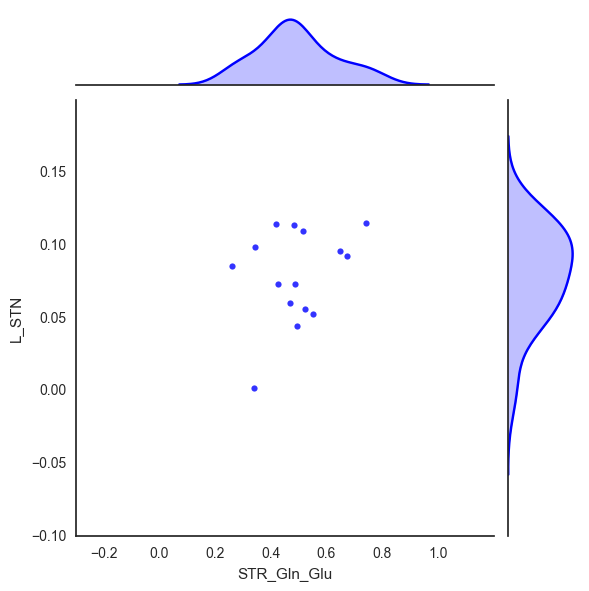

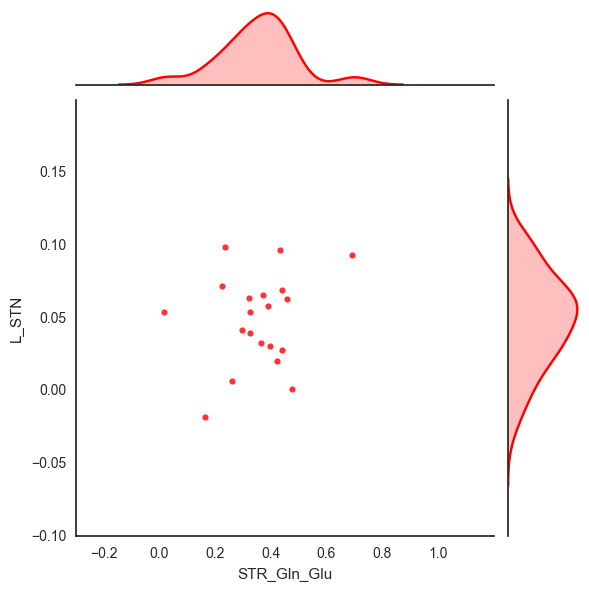

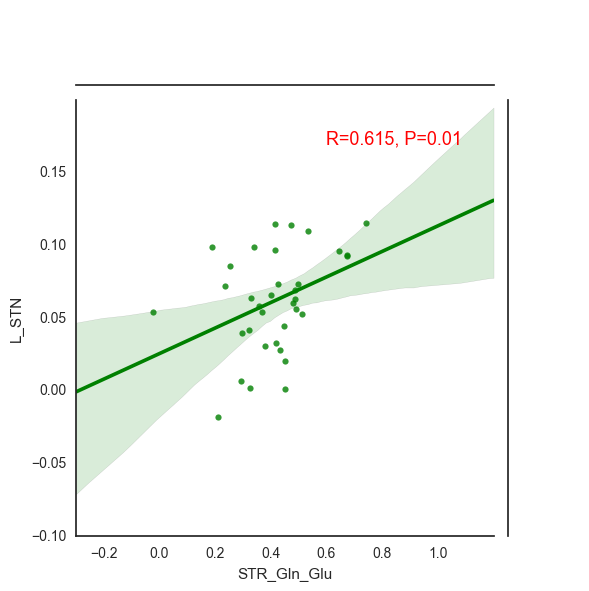

In [415]:
drp = ['SA5U']
df = DF_ALL.drop(drp,axis=0)
x = 'STR_Gln_Glu'
y = 'L_STN'
regressorsx = ['Age', 'Gender']
xlim  = (-.3, 1.2)
ylim  = (-.1,.2)#(-.075,.1750)
dpi = 100 
plot_partial_correlation(controls_a, x, y, regressors = regressorsx, color = 'b', 
                         labels = False, annotate = 0,#(-0.075,1.15), 
                         fit_reg=0, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'r', 
                         labels = False, annotate = 0,#(-0.075,1.075),
                         fit_reg=0, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate = (0.6,0.17), 
                         fit_reg=True, scatter=1, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_agegender_ALL.png'
                        )

### Linear fir with Age/Gender regressed from both axes

Grubbs Outliers [] ['CB4P', 'RA9P']
gESD Outliers [] ['RA9P', 'CB4P']


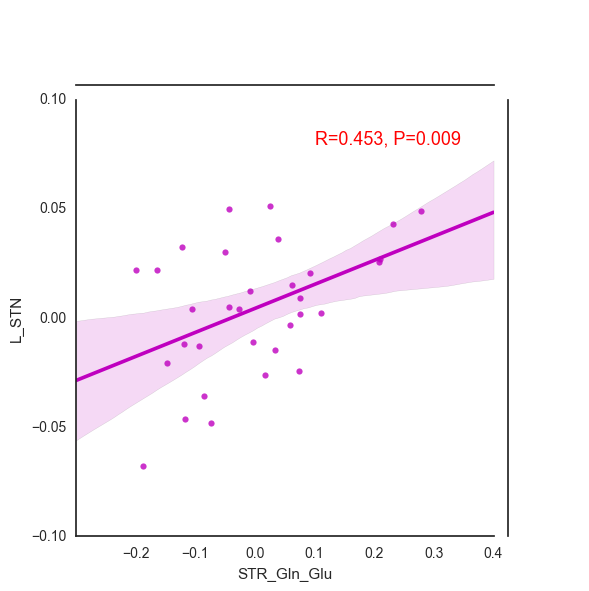

In [416]:
drp = ['SA5U', 'DF2P', 'YU1P', 'KDDP']
df = DF_ALL.drop(drp,axis=0)
x = 'STR_Gln_Glu'
y = 'L_STN'
regressorsx = ['Age', 'Gender']
xlim  = (-.3,.4)#(-.075,.1750)
ylim  = (-.1, .1)

plt_resid(df, x, y, regressors = regressorsx, color = 'm', 
         labels = False, annotate = (0.1,0.08), 
         fit_reg=1, scatter=1, plot_marg = 0,dpi = dpi, xlim=xlim,ylim=ylim,
         #fig_name = 'CORR_LSTN_STRGlnGLu_doublereg_age_gendner_patients.png'
        )

# Relationships with Ferritin

In [417]:
print grubbs_outliers(patients_a, 'CLN_Ferritin', alpha = .05)
print grubbs_outliers(controls_a, 'CLN_Ferritin', alpha = .05)

['SA5U', 'DF2P']
[]


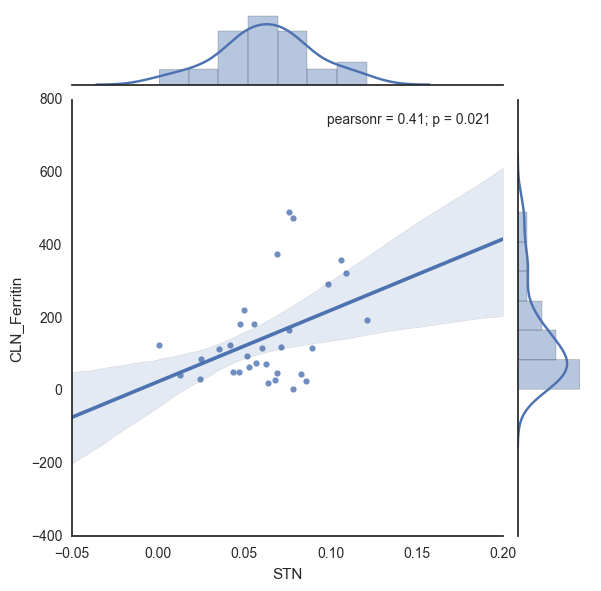

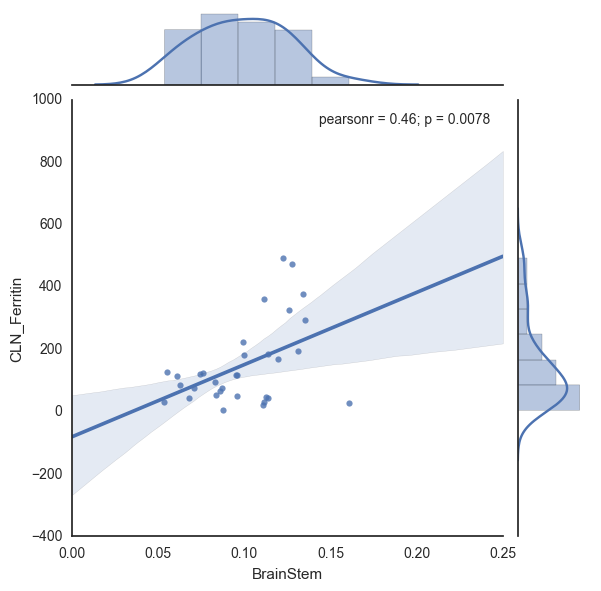

In [418]:
drp = ['SA5U', 'DF2P'] # pu2t outlier in Brainstem
df = DF_ALL.drop(drp,axis=0)
x = 'STN'
y = 'CLN_Ferritin'
plot_joint(df,x,y, drop = [])

x = 'BrainStem'
y = 'CLN_Ferritin'
plot_joint(df,x,y, drop = [])

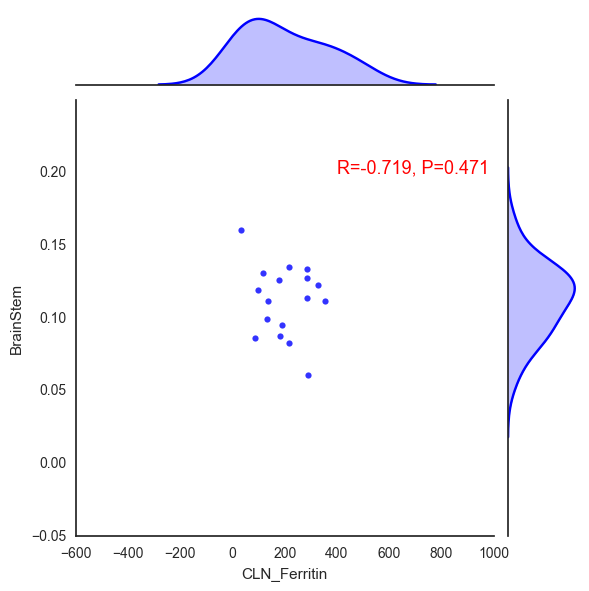

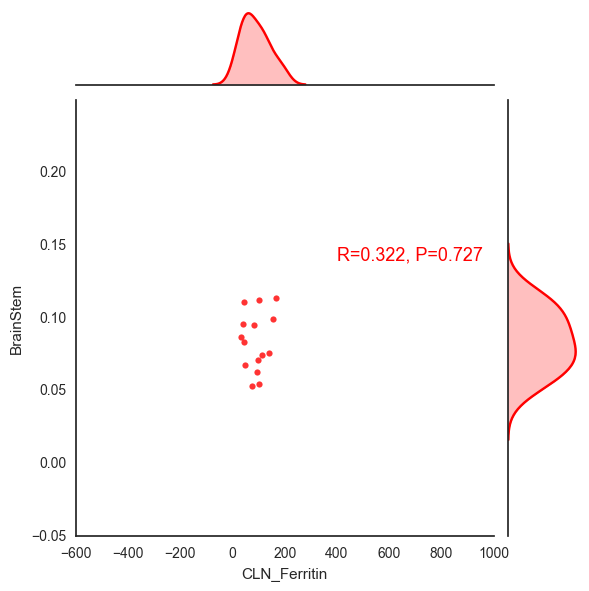

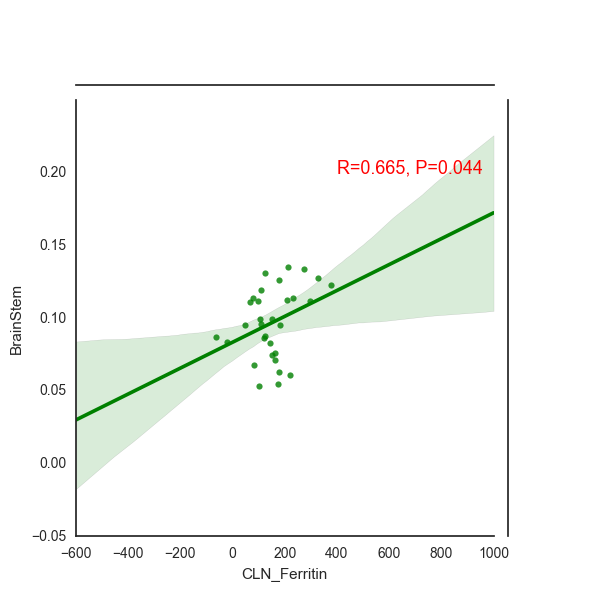

In [436]:
drp = ['DF2P', 'PU2T', 'SA5U']
df = DF_ALL.drop(drp,axis=0)
y = 'BrainStem'
x = 'CLN_Ferritin'
regressorsx = ['Age', 'Gender', 'QI1_MAG']
ylim  = (-.05,.25)#(-.075,.1750)
xlim  = (-600, 1000)
dpi = 100 
plot_partial_correlation(controls_a, x, y, regressors = regressorsx, color = 'b', 
                         labels = False, annotate = (400,0.2), 
                         fit_reg=0, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(['SA5U', 'DF2P'],axis=0), x, y, regressors = regressorsx, color = 'r', 
                         labels = False, annotate = (400,0.14), 
                         fit_reg=0, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate = (400,0.2),  
                         fit_reg=True, scatter=1, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_agegender_ALL.png'
                        )

Grubbs Outliers [] []
gESD Outliers [] []


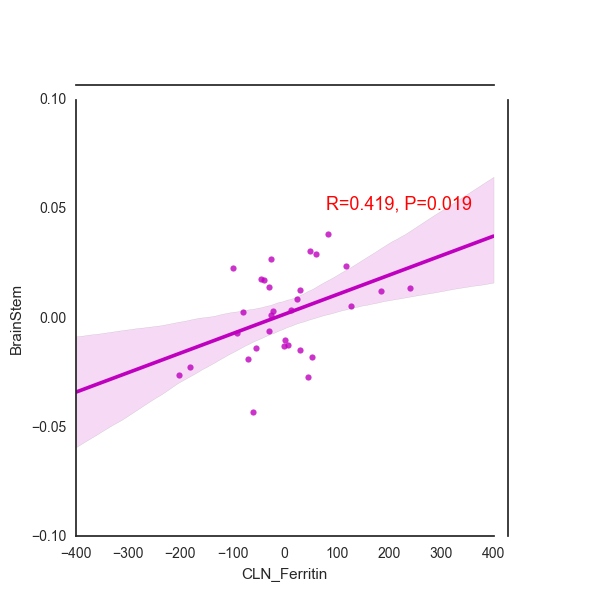

In [441]:
drp = [ 'DF2P', 'SA5U', 'PU2T']
df = DF_ALL.drop(drp,axis=0)
y = 'BrainStem'
x = 'CLN_Ferritin'
regressorsx = ['Age', 'Gender','QI1_MAG']
xlim  = (-400,400)
ylim  = (-.1, 0.1)

plt_resid(df, x, y, regressors = regressorsx, color = 'm', 
         labels = False, annotate = (80,0.05), 
         fit_reg=1, scatter=1, plot_marg = 0,dpi = dpi, xlim=xlim,ylim=ylim,
         #fig_name = 'CORR_LSTN_STRGlnGLu_doublereg_age_gendner_patients.png'
         )
plt.ylabel(y)


### RANSAC Robust linear regression Ferritin - Brain-Stem

In [421]:
from statsmodels.robust.robust_linear_model import RLM
def get_resid(df,measure, regressors):
        formula = [ '%s ~ %s'%(measure,regressors[0])  + ' + %s'%regressor for regressor in regressors[1:]][0]#  
        return smf.ols(formula=formula, data= df).fit().resid
dfx = pd.concat([df[x],df[y]], axis =1).dropna()
dfx['c'] = 1
rlm = RLM(df[x],df[y]).fit()

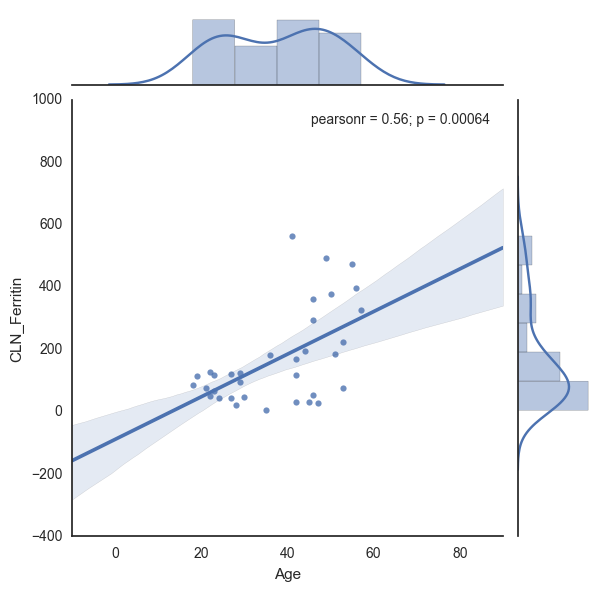

In [422]:
df = DF_ALL
x = 'Age'
y = 'CLN_Ferritin'
plot_joint(df,x,y, drop = [])

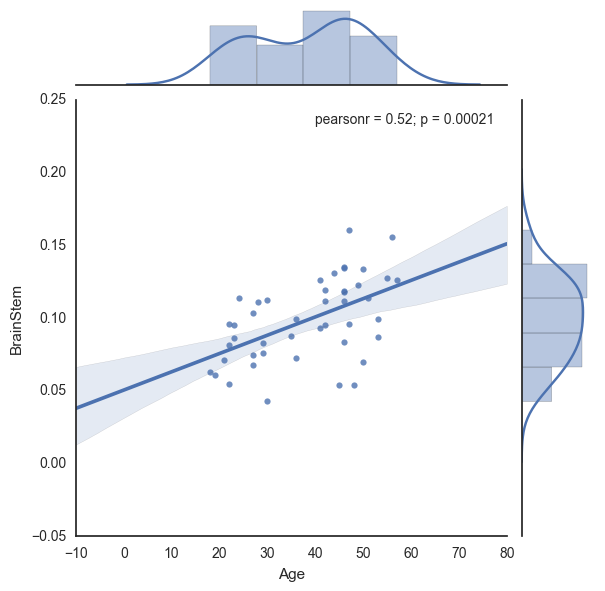

In [423]:
df = DF_ALL
x = 'Age'
y = 'BrainStem'
plot_joint(df,x,y, drop = [])


Estimated coefficients (true, normal, RANSAC):
(array(82.1903908407869), array([ 54.17236387]), array([ 82.08533159]))


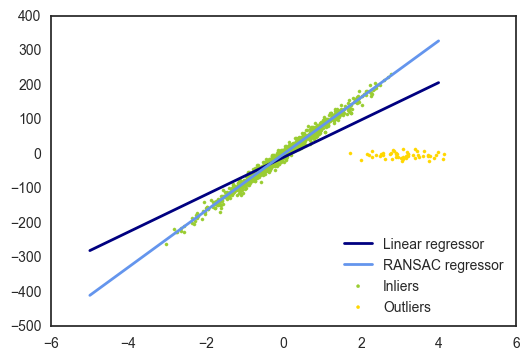

In [424]:

n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
model = linear_model.LinearRegression()
model.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(-5, 5)
line_y = model.predict(line_X[:, np.newaxis])
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

# Compare estimated coefficients
print("Estimated coefficients (true, normal, RANSAC):")
print(coef, model.coef_, model_ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linestyle='-', linewidth=lw,
         label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linestyle='-',
         linewidth=lw, label='RANSAC regressor')
plt.legend(loc='lower right')
plt.show()

In [425]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets



In [426]:
drp = []
df = DF_ALL.drop(drp,axis=0)
x = 'STN'
y = 'CLN_Ferritin'
regressorsx = ['Age', 'Gender']
xlim  = None#(-.1,.2)#(-.075,.1750)
ylim  = None#(-.4, 1.2)

x_resid = get_resid(df,x, regressorsx)
y_resid = get_resid(df,y, regressorsx)
#print grubbs_outliersx(x_resid)
#print grubbs_outliersx(y_resid)
dfx = pd.concat([x_resid, y_resid], axis=1).dropna()
dfx.columns = [x,y]


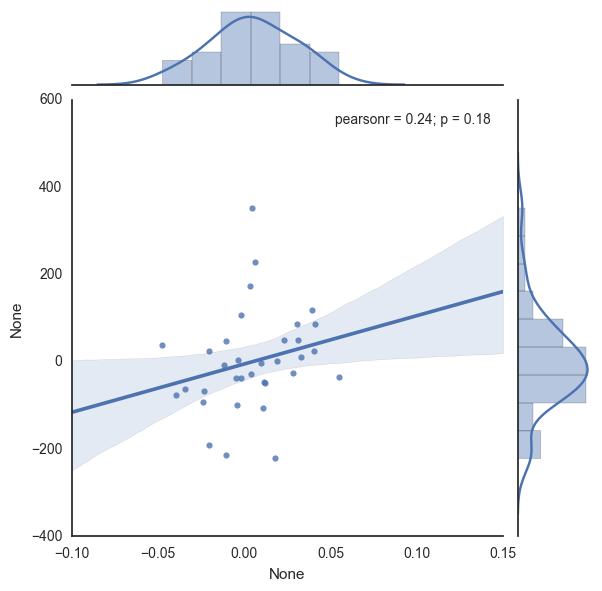

In [427]:
sns.jointplot(x_resid, y_resid, kind='reg')

In [428]:
X = dfx[x].values.reshape(34,1)
y = dfx['CLN_Ferritin'].values.reshape(34,1)
print len(X)
print len(y)

34
34


In [429]:
# Fit line using all data
model = linear_model.LinearRegression()
model.fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [430]:

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)


Estimated coefficients (true, normal, RANSAC):
(array(82.1903908407869), array([[ 1105.15129473]]), array([[ 1533.74768833]]))


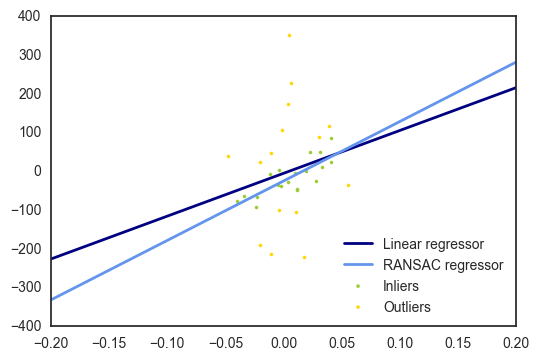

In [431]:
# Predict data of estimated models
line_X = np.arange(-5, 5)
line_y = model.predict(line_X[:, np.newaxis])
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

# Compare estimated coefficients
print("Estimated coefficients (true, normal, RANSAC):")
print(coef, model.coef_, model_ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linestyle='-', linewidth=lw,
         label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linestyle='-',
         linewidth=lw, label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlim(-0.2,0.2)
plt.ylim(-400,400)
plt.show()

In [432]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('CLN_Ferritin ~ BrainStem + Age + Gender', data=df, return_type='dataframe')
thresh = 5.0
variables = range(X.shape[1])

for i in np.arange(0,len(variables)):
    vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]
    print(vif)
    maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
        del variables[maxloc]

print('Remaining variables:')
print(X.columns[variables])

[16.30610394715513, 1.6490227904008448, 1.6519884949878481, 1.0072271770386749]
dropping 'Intercept' at index: 0
[16.45365783141046, 16.296625450649476, 1.1430317238492025]
dropping 'BrainStem' at index: 0
[1.1320971965167552, 1.1320971965167552]
[1.1320971965167552, 1.1320971965167552]
Remaining variables:
Index([u'Age', u'Gender'], dtype='object')


In [433]:
y, X = dmatrices('CLN_Ferritin ~ BrainStem + Age + Gender', data=df, return_type='dataframe')


In [434]:
X

,Intercept,BrainStem,Age,Gender
SMVX,1.0,0.060947,19.0,0.0
STQT,1.0,0.085967,23.0,0.0
HM1X,1.0,0.095512,23.0,0.0
TR4T,1.0,0.113852,24.0,1.0
PAHT,1.0,0.082735,29.0,0.0
RJJT,1.0,0.087851,35.0,1.0
SDCT,1.0,0.111642,42.0,1.0
HM2X,1.0,0.119483,42.0,0.0
MJBT,1.0,0.131179,44.0,0.0
GHAT,1.0,0.135284,46.0,0.0


In [435]:
sns.jointplot()

TypeError: jointplot() takes at least 2 arguments (0 given)

In [ ]:
drp = ['SA5U']
df = DF_ALL#.drop(drp,axis=0)
x = 'Age'
y = 'SN'
regressorsx = ['Age', 'Gender']
xlim  = None #(-.4, 1.2)
ylim  = None#(-.15,.2)#(-.075,.1750)
dpi = 100 

plot_joint(df,x,y, drop = [])


In [ ]:

plot_partial_correlation(controls_a, x, y, regressors = regressorsx, color = 'b', 
                         labels = False, annotate = 0,#(-0.075,1.15), 
                         fit_reg=0, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'r', 
                         labels = False, annotate = 0,#(-0.075,1.075),
                         fit_reg=0, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate = (0.6,0.17), 
                         fit_reg=True, scatter=1, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                        # fig_name = 'CORR_LSTN_STRGlnGLu_reg_agegender_ALL.png'
                        )